In [1]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib
import math

pd.options.display.max_columns=100
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Load TMB, neoepitope burden and GIE events per sample

In [4]:
# Load GIE events
df_d = pd.read_csv("../results/data/features_correlation/randomized_escape_for_features.tsv.gz",sep="\t")
df_d1 = pd.read_csv("../results/data/features_correlation/escape_for_features.tsv",sep="\t")
# Load metadata
df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t")
# Load primary and metastatic information across all samples
df_met = pd.read_csv("../results/data/processed_hmf_escape_info.tsv.gz",sep="\t")
df_primary = pd.read_csv("../results/data/processed_pcawg_escape_info.tsv.gz",sep="\t")
# Load number of neoepitopes and TMB per sample
df_counts_neo = pd.read_csv("../results/data/features_correlation/sample_specific_info_tmb_full_data.tsv",sep="\t")
df_meta=df_meta[(df_meta["is_selected"]==True)][["sample_id","sv_load","smnv_load","sbs_load.clonal","dbs_load.clonal","indel_load.clonal","sbs_load.subclonal","dbs_load.subclonal","indel_load.subclonal"]]
df = pd.concat([df_primary,df_met]).merge(df_meta)
print (df.shape[0])
df = df.merge(df_counts_neo[["sample_id","total_neo","fusion_neo","mut_neo","clonal_neo","subclonal_neo"]],how="left")
df["is_wt"] = df.apply(lambda row: not(row["genetic_immune_escape"]),axis=1)
df["clonal_tmb"] = df["sbs_load.clonal"] + df["dbs_load.clonal"] + df["indel_load.clonal"]
df["subclonal_tmb"] = df["sbs_load.subclonal"] + df["dbs_load.subclonal"] + df["indel_load.subclonal"]
df["log_tmb"] = np.log10(df["smnv_load"])
df["log_clonal"] = np.log10(df["clonal_tmb"])
df["log_subclonal"] = np.log10(df["subclonal_tmb"]+1)
df["log_clonal_neo"] = np.log10(df["clonal_neo"]+1)
df["log_neo"] = np.log10(df["total_neo"]+1)
df["log_subclonal_neo"] = np.log10(df["subclonal_neo"]+1)
df = df.merge(df_d).merge(df_d1)

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6319


/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Read simulated GIE

In [5]:
df_background_hmf = pd.read_csv("../results/data/hmf_randomized_genes_background_processed.tsv.gz",sep="\t")
df_background_pcawg = pd.read_csv("../results/data/pcawg_randomized_genes_background_processed.tsv.gz",sep="\t")
df_background = pd.concat([df_background_hmf,df_background_pcawg])
df_background = df_background.merge(df_meta)
df_background["clonal_tmb"] = df_background["sbs_load.clonal"] + df_background["dbs_load.clonal"] + df_background["indel_load.clonal"]
df_background["subclonal_tmb"] = df_background["sbs_load.subclonal"] + df_background["dbs_load.subclonal"] + df_background["indel_load.subclonal"]
df_background["log_tmb"] = np.log10(df_background["smnv_load"])
df_background["log_clonal"] = np.log10(df_background["clonal_tmb"])
df_background["log_subclonal"] = np.log10(df_background["subclonal_tmb"]+1)
df_background = df_background.merge(df_counts_neo[["sample_id","total_neo","fusion_neo","mut_neo","clonal_neo","subclonal_neo"]],how="left")
df_background["log_neo"] = np.log10(df_background["total_neo"]+1)
df_background["log_clonal_neo"] = np.log10(df_background["clonal_neo"]+1)
df_background["log_subclonal_neo"] = np.log10(df_background["subclonal_neo"]+1)
df_background = df_background.merge(df_d).merge(df_d1)

### Aux functions

In [6]:
def p75_log(grp):
    return np.log10(np.nanpercentile(grp,[75]))
def p25_log(grp):
    return np.log10(np.nanpercentile(grp,[25]))
def med_log(grp):
    return np.log10(np.nanmedian(grp))
def prev(grp):
    return np.nansum(grp) / len(grp)
def p75(grp):
    return np.nanpercentile(grp,[75])
def p25(grp):
    return np.nanpercentile(grp,[25])

In [7]:
def generate_randomizations_tmb_buckets(df,nbins,tolerance_base=0.05,column_query="loh_lilac",generate_thresholds=True,thresholds_given=[],simulations=1000,column_eval="log_tmb",fraction=0.5):
    bins=nbins
    if column_eval == "log_tmb":
        min_v=np.nanmin(np.percentile(df[column_eval],1))
        max_v=np.nanmax(np.percentile(df[column_eval],99))
    else:
        min_v=np.nanmin(np.percentile(df[column_eval],1))
        max_v=np.nanmax(np.percentile(df[column_eval],99))

    if generate_thresholds:
        thresholds=list(np.linspace(min_v,max_v,bins))
    else:
        thresholds=thresholds_given
    tolerance=tolerance_base
    values_y,sizes,sizes_total=[],[], []
    for i,t in enumerate(thresholds):
        if i==0:
            q=df[(df[column_eval]<=thresholds[i])]
        elif i==len(thresholds)-1: # last
            q=df[(df[column_eval]>thresholds[i-1])]
        else:
            q=df[(df[column_eval]>thresholds[i-1])&(df[column_eval]<=thresholds[i])]
        
        
        
        if q[q[column_query]].shape[0]==0:
            sizes.append(0)
            sizes_total.append(q.shape[0])
            values_y.append(np.zeros(simulations))
            continue
        tmp=[]
        sizes.append(q[q[column_query]].shape[0])
        sizes_total.append(q.shape[0])
        for _ in range(simulations):
            sim=q.sample(frac=fraction,replace=True)
            if sim.shape[0] == 0:
                tmp.append(0.0)
                continue
            tmp.append(sum(sim[column_query])/sim.shape[0])
        values_y.append(tmp)
    return values_y,thresholds,sizes,sizes_total


def plot_risk(values_y,thresholds,sizes,sizes_total,title,color="black",ylabel="LOH HLA risk",transform="TMB",bins=20,name="",ylim=(-0.05,1.0),savefig=False,plot_axvline=True,resolution="normal"):
    mean=np.nanmean(np.array(values_y),axis=1)
    std = np.nanstd(np.array(values_y),axis=1)
    upper=[mean[i]+std[i] for i in range(len(mean))]
    lower=[mean[i]-std[i] for i in range(len(mean))]
    fig,ax=plt.subplots(figsize=(8,5))
    gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[1,3])
    gs.update(hspace=0.1, wspace=0.0)
    # distplot
    ax0 = plt.subplot(gs[0])
    
    ax0.bar(x=[v for v in range(0,len(thresholds))],height=sizes,color=color,alpha=0.5,edgecolor="black",lw=0.5,width=0.8)
    ax0.plot([v for v in range(0,len(thresholds))],sizes,lw=2,color=color)
    
    ax0.bar(x=[v for v in range(0,len(thresholds))],height=sizes_total,color="white",alpha=0.5,edgecolor="black",lw=0.5,width=0.8)
    ax0.plot([v for v in range(0,len(thresholds))],sizes_total,lw=2,color="black")
    ax0.set_xlim(-1,len(thresholds))
    ax0.set_xticks([v for v in range(0,len(thresholds))])
    ax0.set_xticklabels([])
    ax0.set_yticks(range(0,900,200))
    # risk
    ax1 = plt.subplot(gs[1])
    ax1.fill_between(x=thresholds, y1=lower, y2=upper, color=color, alpha=0.15 )
    ax1.plot(thresholds,mean,lw=4,color=color)
    ax1.errorbar(thresholds,mean,color=color,yerr=std,fmt='o',elinewidth=1.9,markersize=6)
    
    
    #_=ax1.set_xticks(list(range(0,len(thresholds))))
    if transform=="TMB":
        #_=ax1.set_xticklabels([f"{int(10**t)/3000:.4f}" for t in thresholds],rotation=90,fontsize=12)
        ax1.set_xticks(thresholds)
        if resolution == "high":
            ax1.set_xticklabels(["{:.4f}".format(10**i/3000) for i in thresholds[:-1]]+[">"+"{:.2f}".format(10**thresholds[-2]/3000)],rotation=90,fontsize=12)     
        else:
            ax1.set_xticklabels(["{:.2f}".format(10**i/3000) for i in thresholds[:-1]]+[">"+"{:.2f}".format(10**thresholds[-2]/3000)],rotation=90,fontsize=12)     
        ax1.set_xlabel("TMB bucket (Muts/Mb)",fontsize=12)
    elif transform=="TML":
        #
        ax1.set_xticks(thresholds)
        ax1.set_xticklabels([f"{int(10**i)}" for i in thresholds[:-1]]+[">"+"{:.1e}".format(int(10**thresholds[-2]))],rotation=90,fontsize=12)
        ax1.set_xlabel(f"{name} bucket",fontsize=12)
        for t in thresholds:
            ax1.annotate(xy=(t,-0.25),s=f"{int(10**t*0.01)}",rotation=0,fontsize=8, annotation_clip=False)
            ax1.annotate(xy=(t,-0.3),s=f"{int(10**t*0.05)}",rotation=0,fontsize=8, annotation_clip=False)
    else:
        _=ax1.set_xticklabels([f"{t:.2f}" for t in thresholds],rotation=90,fontsize=12)
        ax1.set_xlabel(name,fontsize=12)
    
    ax1.set_ylabel(ylabel,fontsize=12)
    ax0.set_title(title)
    #ax0.set_xlim(thresholds[0],thresholds[-1])
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax0.set_ylabel("# samples",fontsize=12)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    if plot_axvline and transform =="TMB":
        ax1.axvline(x=np.log10(30*10**3),color="grey",ls="--")
        ax1.annotate(xy=(np.log10(30*10**3),0.6),s="10mut/Mb",fontsize=12)
        ax1.axvline(x=np.log10(90*10**3),color="grey",ls="--")
        ax1.annotate(xy=(np.log10(90*10**3),0.7),s="30mut/Mb",fontsize=12)
    
    ax1.set_ylim(ylim)
    if savefig:

        plt.savefig(f'../results/figures/figure8/tmb_vs_gie_{name}.pdf', dpi=800,bbox_inches="tight")
        
def plot_risk_multiple(l_values_y,thresholds,title,sizes_total, sizes, colors=["grey"],ylabel="LOH HLA risk",transform="TMB",bins=20,name="",ylim=(-0.05,1.0),savefig=False,plot_axvline=True,plot_total=False,labels=[],sizeplot=(8,5),markers=["o"],ttype_specific=False, resolution="normal"):

    fig,ax=plt.subplots(figsize=sizeplot)
    gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[1,3])
    gs.update(hspace=0.1, wspace=0.0)
    # distplot
    ax0 = plt.subplot(gs[0])
    ax0.set_xticklabels([])
    ax0.set_xlim(-1,len(thresholds))
    ax0.set_xticks([v for v in range(0,len(thresholds)) ])
    for i,s in enumerate(sizes):
        ax0.bar(x=[v for v in range(0,len(thresholds))],height=s,color=colors[i],alpha=0.25,edgecolor="black",lw=0.5,width=0.8,zorder=i)
        ax0.plot([v for v in range(0,len(thresholds))],s,lw=4,color=colors[i],alpha=1.0)
    if plot_total:
        if ttype_specific:
            ax0.bar(x=[v for v in range(0,len(thresholds))],height=sizes_total,color="white",alpha=0.25,edgecolor="black",lw=1.0,width=0.8)
            ax0.plot([v for v in range(0,len(thresholds))],sizes_total,lw=3,color="black")
            maxv=np.nanmax(sizes_total)
            result_1 = round(maxv, -2)
            ax0.set_yticks(range(0,result_1+50,50))
        else:
             
            ax0.bar(x=[v for v in range(0,len(thresholds))],height=sizes_total,color="white",alpha=0.25,edgecolor="black",lw=1.0,width=0.8)
            ax0.plot([v for v in range(0,len(thresholds))],sizes_total,lw=3,color="black")
            ax0.set_yticks(range(0,900,200))
    else:
       
        ax0.set_yticks(range(0,175,25))

        
    
    # risk
    ax1 = plt.subplot(gs[1])
    for j,values_y in enumerate(l_values_y):
        mean=np.nanmean(np.array(values_y),axis=1)
        std = np.nanstd(np.array(values_y),axis=1)
        upper=[mean[i]+std[i] for i in range(len(mean))]
        lower=[mean[i]-std[i] for i in range(len(mean))]

        ax1.fill_between(x=thresholds, y1=lower, y2=upper, color=colors[j], alpha=0.15 )
        ax1.plot(thresholds,mean,lw=3,color=colors[j])
        if len(markers)  == len(l_values_y):
            ax1.errorbar(thresholds,mean,color=colors[j],yerr=std,fmt='o',elinewidth=1.5,markersize=8,marker=markers[j])
        else:
            ax1.errorbar(thresholds,mean,color=colors[j],yerr=std,fmt='o',elinewidth=1.5,markersize=5)
    
    
    #_=ax1.set_xticks(list(range(0,len(thresholds))))
    if transform=="TMB":
        #_=ax1.set_xticklabels([f"{int(10**t)/3000:.4f}" for t in thresholds],rotation=90,fontsize=12)
        ax1.set_xticks(thresholds)
        if resolution == "high":
            ax1.set_xticklabels(["{:.4f}".format(10**i/3000) for i in thresholds[:-1]]+[">"+"{:.2f}".format(10**thresholds[-2]/3000)],rotation=90,fontsize=16)     
        else:
            ax1.set_xticklabels(["{:.2f}".format(10**i/3000) for i in thresholds[:-1]]+[">"+"{:.2f}".format(10**thresholds[-2]/3000)],rotation=90,fontsize=16)     
        
        ax1.set_xlabel("TMB bucket (Muts/Mb)",fontsize=16)
    elif transform=="TML":
        #
        ax1.set_xticks(thresholds)
        ax1.set_xticklabels([f"{int(10**i)}" for i in thresholds[:-1]]+[">"+f"{int(10**thresholds[-2])}"],rotation=90,fontsize=16)
        for t in thresholds:
            ax1.annotate(xy=(t,-0.25),s=f"{int(10**t*0.01)}",rotation=0,fontsize=8, annotation_clip=False)
            ax1.annotate(xy=(t,-0.35),s=f"{int(10**t*0.05)}",rotation=0,fontsize=8, annotation_clip=False)
        
        
    else:
        _=ax1.set_xticklabels([f"{t:.2f}" for t in thresholds],rotation=90,fontsize=12)
        ax1.set_xlabel(name,fontsize=12)

    
    ax1.set_ylabel(ylabel,fontsize=16)
    ax0.set_title(title,fontsize=18)
    #ax0.set_xlim(thresholds[0],thresholds[-1])
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax0.set_ylabel("# samples",fontsize=12)
    ax0.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    if plot_axvline and transform=="TMB":
        ax1.axvline(x=np.log10(30*10**3),color="grey",ls="--")
        ax1.annotate(xy=(np.log10(30*10**3),0.6),s="10mut/Mb",fontsize=16)
        ax1.axvline(x=np.log10(90*10**3),color="grey",ls="--")
        ax1.annotate(xy=(np.log10(90*10**3),0.7),s="30mut/Mb",fontsize=16)
        ax1.axvline(x=thresholds[-1],color="grey",ls="--")
        ax1.annotate(xy=(thresholds[-1],0.7),s="95/Mb",fontsize=16)
    
    ax1.set_ylim(ylim)
    markers = [plt.Line2D([0,0],[0,0],color=c, marker='o') for c in colors]
    ax1.legend(markers, labels, numpoints=1,fontsize=16,loc="upper left")
    if savefig:
        plt.savefig(f'../results/figures/figure8/tmb_vs_gie_{name}.pdf', dpi=800,bbox_inches="tight")

### Analysis of GIE events and simulated GIE across TMB buckets, 

GIE events do not include non-focal LOH

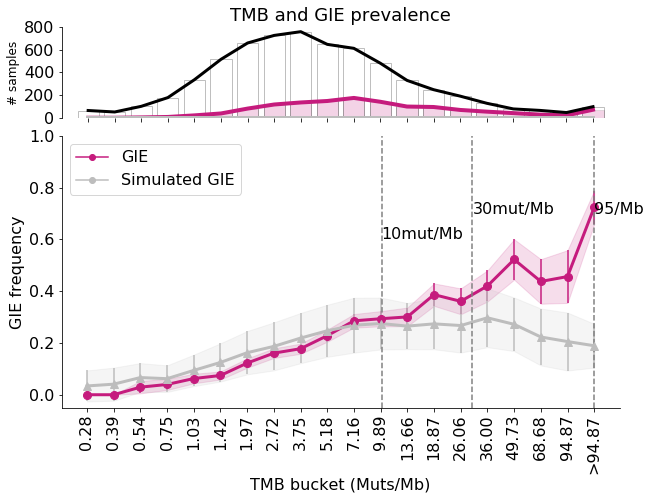

In [129]:

values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="selected_genetic_immune_escape")
v=[]
for i in range(100):
    values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background,nbins=20,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",fraction=1.0)
    v.append(values_y_background)

values_y_background=np.array(v).T[0]
plot_risk_multiple([values_y,values_y_background],thresholds,title="TMB and GIE prevalence",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                   ,name="excl_nfloh_gie_combined_with_simulated_gie",savefig=True,markers=["o","^"]
                   ,ylim=(-0.05,1.0),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True)

### Subset by clonal mutations

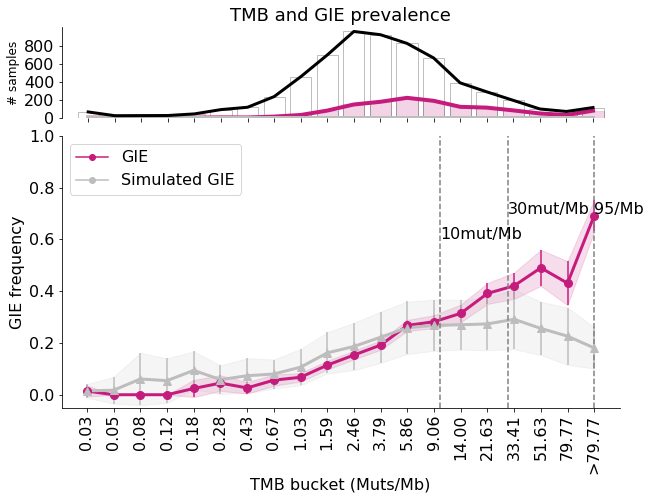

In [130]:

values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="selected_genetic_immune_escape",column_eval="log_clonal")
v=[]
for i in range(100):
    values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background,nbins=20,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",column_eval="log_clonal",fraction=1.0)
    v.append(values_y_background)

values_y_background=np.array(v).T[0]
plot_risk_multiple([values_y,values_y_background],thresholds,title="TMB and GIE prevalence",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                   ,name="excl_nfloh_gie_combined_with_simulated_gie_clonal",savefig=True,markers=["o","^"]
                   ,ylim=(-0.05,1.0),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True)

### Subset by clonal mutations

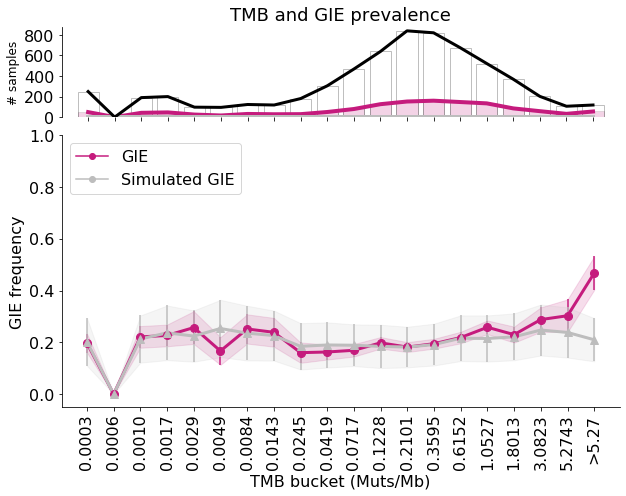

In [131]:

values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="selected_genetic_immune_escape",column_eval="log_subclonal")
v=[]
for i in range(100):
    values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background,nbins=20,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",column_eval="log_subclonal",fraction=1.0)
    v.append(values_y_background)

values_y_background=np.array(v).T[0]
plot_risk_multiple([values_y,values_y_background],thresholds,title="TMB and GIE prevalence",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                   ,name="excl_nfloh_gie_combined_with_simulated_gie_subclonal",savefig=True,markers=["o","^"]
                   ,ylim=(-0.05,1.0),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True,plot_axvline=False,resolution="high")

### Cancer type specific analyses

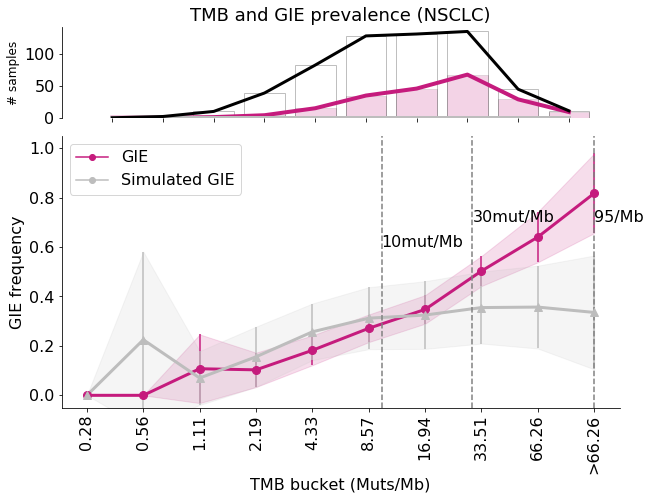

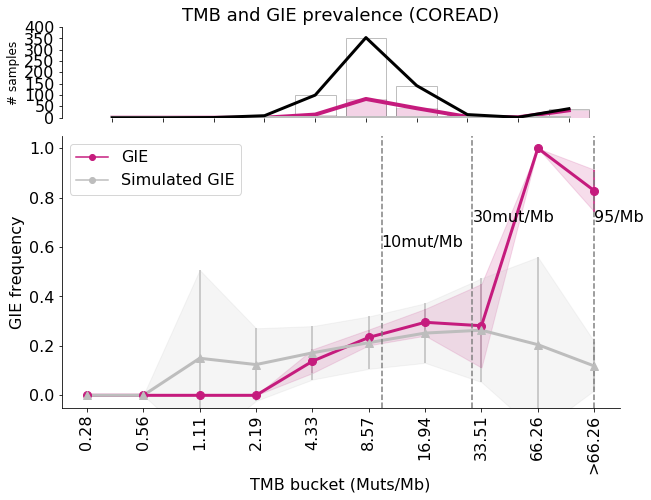

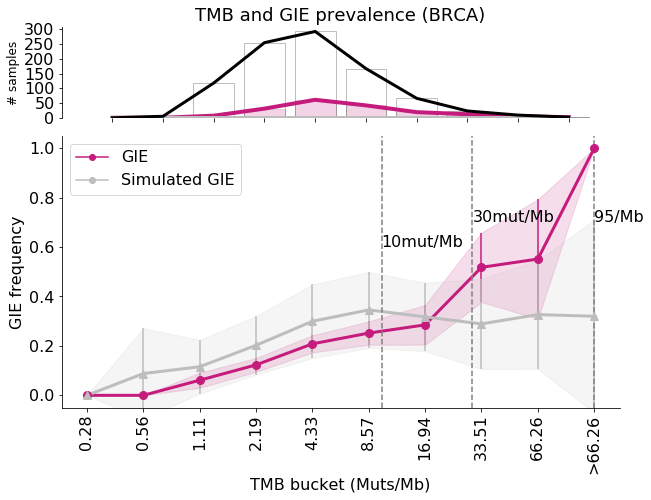

In [132]:
ttypes =["NSCLC","COREAD","BRCA"] # cancer type with a broad TMB representation and ample sample size
values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,10,simulations=1000,column_query="selected_genetic_immune_escape")
for ttype in ttypes:
    values_y,_,sizes,sizes_total=generate_randomizations_tmb_buckets(df[df["cancer_type_code"]==ttype],10,simulations=1000,column_query="selected_genetic_immune_escape",generate_thresholds=False,thresholds_given=thresholds)
    v=[]
    for i in range(100):
        values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background[df_background["cancer_type_code"]==ttype],nbins=10,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",fraction=1.0)
        v.append(values_y_background)

    values_y_background=np.array(v).T[0]
    plot_risk_multiple([values_y,values_y_background],thresholds,title=f"TMB and GIE prevalence ({ttype})",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                       ,name=f"excl_nfloh_gie_combined_with_simulated_gie_{ttype}",savefig=True,markers=["o","^"]
                       ,ylim=(-0.05,1.05),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True,ttype_specific=True)##4d9221"
    

# Split the analysis by type of GIE event 

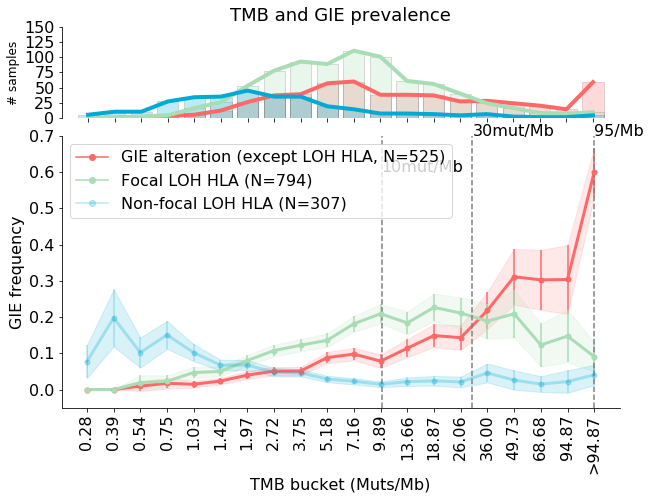

In [106]:
df["flag"] = df.apply(lambda row: row["genetic_immune_escape"] and not(row["loh_lilac"]),axis=1)
df["loh_focal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_focal"]),axis=1)
df["loh_nonfocal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_nonfocal"]),axis=1)

values_y,thresholds,sizes_gie,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="flag")
values_y_loh,thresholds,sizes_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_focal_flag")
values_y_loh2,thresholds,sizes_non_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_nonfocal_flag")

plot_risk_multiple([values_y,values_y_loh,values_y_loh2],thresholds,title="TMB and GIE prevalence",sizes_total=sizes_total,sizes=[sizes_gie,sizes_foc,sizes_non_foc],colors=["#FF6868","#a8ddb5","#00aad445"],ylabel="GIE frequency",savefig=True,name="gie_loh_focal_model_comb_full",sizeplot=(10,7)
                   ,ylim=(-0.05,0.7),labels=[f"GIE alteration (except LOH HLA, N={sum(sizes_gie)})",f"Focal LOH HLA (N={sum(sizes_foc)})",f"Non-focal LOH HLA (N={sum(sizes_non_foc)})"])

In [111]:
10**thresholds[13] / 3000

18.870719767028103

In [112]:
np.nanmean(values_y_loh[:][13])

0.2267016129032258

In [113]:
np.nanstd(values_y_loh[:][13])

0.03789007922316845

### Split by specific pathway

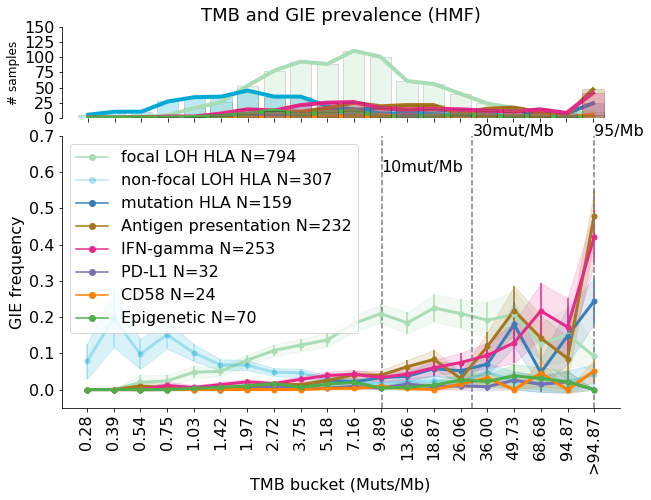

In [103]:
df["flag"] = df.apply(lambda row: row["genetic_immune_escape"] and not(row["loh_lilac"]),axis=1)
df["loh_focal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_focal"]),axis=1)
df["loh_nonfocal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_nonfocal"]),axis=1)
#'systemic_app_pathway',        'cd58_pathway',  'ifn_gamma_pathway',  'checkpoint_pathway', 'epigenetic_regulators_pathway',

values_y_loh,thresholds,sizes_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_focal_flag")
values_y_loh2,thresholds,sizes_non_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_nonfocal_flag")
values_y_mut,thresholds,sizes_mut,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="mut_hla_lilac")
values_y1,thresholds,sizes_gie1,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="systemic_app_pathway")
values_y2,thresholds,sizes_gie2,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="ifn_gamma_pathway")
values_y3,thresholds,sizes_gie3,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="checkpoint_pathway")
values_y4,thresholds,sizes_gie4,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="cd58_pathway")
values_y5,thresholds,sizes_gie5,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="epigenetic_regulators_pathway")


plot_risk_multiple([values_y_loh,values_y_loh2,values_y_mut,values_y1,values_y2,values_y3,values_y4,values_y5],thresholds,title="TMB and GIE prevalence (HMF)",sizes_total=sizes_total,sizes=[sizes_foc,sizes_non_foc,sizes_mut,sizes_gie1,sizes_gie2,sizes_gie3,sizes_gie4,sizes_gie5],colors=["#a8ddb5","#00aad445","#377eb8","#a6761d","#e7298a","#7570b3","#ff7f00","#4daf4a"],ylabel="GIE frequency"
                   ,savefig=True
                   ,name="gie_loh_focal_model_comb_full_all_pathways"
                   ,ylim=(-0.05,0.7),
                   labels=[f"focal LOH HLA N={sum(sizes_foc)}",f"non-focal LOH HLA N={sum(sizes_non_foc)}",f"mutation HLA N={sum(sizes_mut)}",f"Antigen presentation N={sum(sizes_gie1)}",
                           f"IFN-gamma N={sum(sizes_gie2)}",f"PD-L1 N={sum(sizes_gie3)}",f"CD58 N={sum(sizes_gie4)}",f"Epigenetic N={sum(sizes_gie5)}"],sizeplot=(10,7))##4d9221"


In [123]:
df[df["flag"]].shape

(526, 368)

In [124]:
df[df["loh_focal_flag"]].shape

(794, 368)

In [125]:
df[df["loh_nonfocal_flag"]].shape

(307, 368)

In [91]:
1.1*10**4 / 3000

3.6666666666666665

In [95]:
print (10**thresholds[11])
print (np.nanmean([values_y_loh[:][12]]),np.nanstd([values_y_loh[:][12]])) 


29558.81856774235
0.18689349112426035 0.029330719924047396


# Using neoepitopes as baseline, instead of TMB

### Excluding non-focal LOH

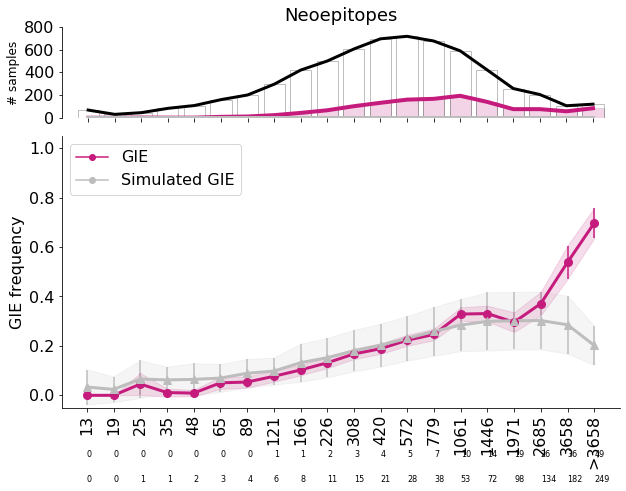

In [133]:

values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="selected_genetic_immune_escape",column_eval="log_neo")
v=[]
for i in range(100):
    values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background,nbins=20,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",column_eval="log_neo",fraction=1.0)
    v.append(values_y_background)

values_y_background=np.array(v).T[0]
plot_risk_multiple([values_y,values_y_background],thresholds,title="Neoepitopes",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                   ,name="full_gie_combined_with_simulated_gie_neoepitopes",savefig=True,markers=["o","^"]
                   ,ylim=(-0.05,1.05),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True,transform="TML",plot_axvline=False)##4d9221"

### Cancer type specific analysis

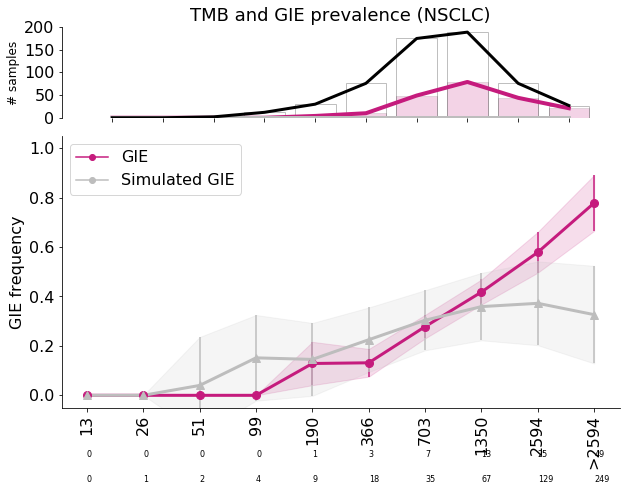

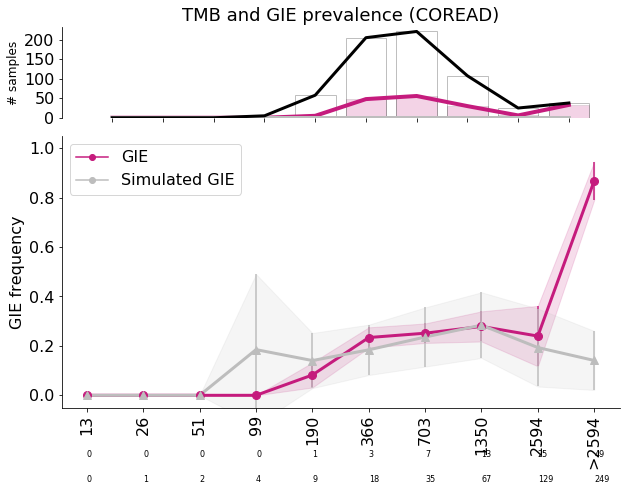

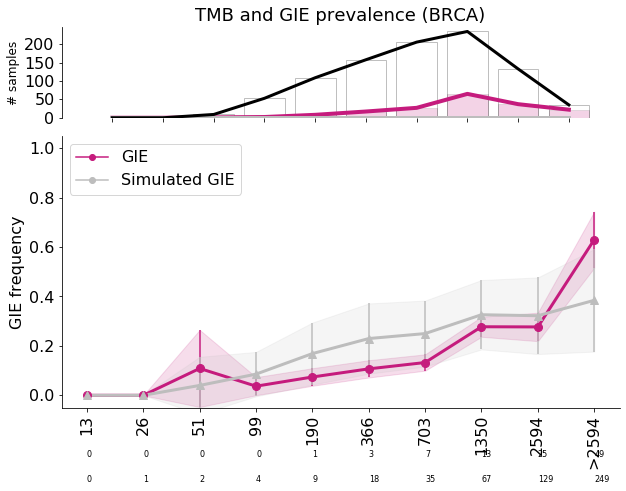

In [93]:
ttypes =["NSCLC","COREAD","BRCA"]
values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,10,simulations=1000,column_query="selected_genetic_immune_escape",column_eval="log_neo")
for ttype in ttypes:
    values_y,_,sizes,sizes_total=generate_randomizations_tmb_buckets(df[df["cancer_type_code"]==ttype],10,simulations=1000,column_query="selected_genetic_immune_escape",generate_thresholds=False,thresholds_given=thresholds,column_eval="log_neo")
    v=[]
    for i in range(100):
        values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background[df_background["cancer_type_code"]==ttype],nbins=10,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",column_eval="log_neo")
        v.append(values_y_background)

    values_y_background=np.array(v).T[0]
    plot_risk_multiple([values_y,values_y_background],thresholds,title=f"TMB and GIE prevalence ({ttype})",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                       ,name=f"excl_nfloh_gie_combined_with_simulated_gie_neo_{ttype}",savefig=True,markers=["o","^"]
                       ,ylim=(-0.05,1.05),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True,transform="TML",plot_axvline=False,ttype_specific=True)##4d9221"

### Clonal neoepitopes

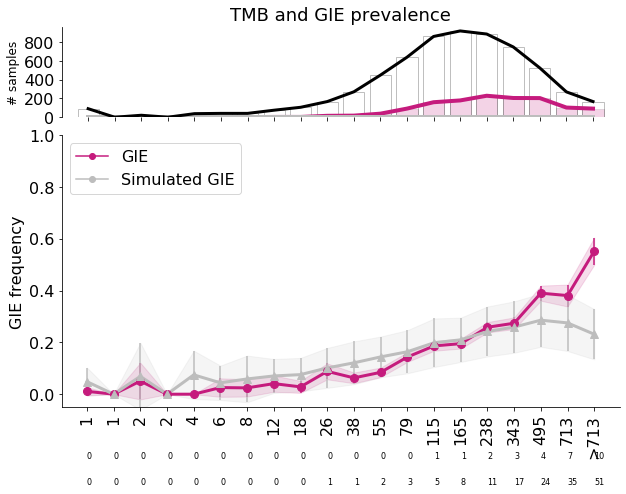

In [94]:

values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="selected_genetic_immune_escape",column_eval="log_clonal_neo")
v=[]
for i in range(100):
    values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background,nbins=20,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",column_eval="log_clonal_neo")
    v.append(values_y_background)

values_y_background=np.array(v).T[0]
plot_risk_multiple([values_y,values_y_background],thresholds,title="TMB and GIE prevalence",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                   ,name="excl_nfloh_gie_combined_with_simulated_gie_clonal_neo",savefig=True,markers=["o","^"]
                   ,ylim=(-0.05,1.0),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True,transform="TML",plot_axvline=False)

### Subclonal neoepitopes

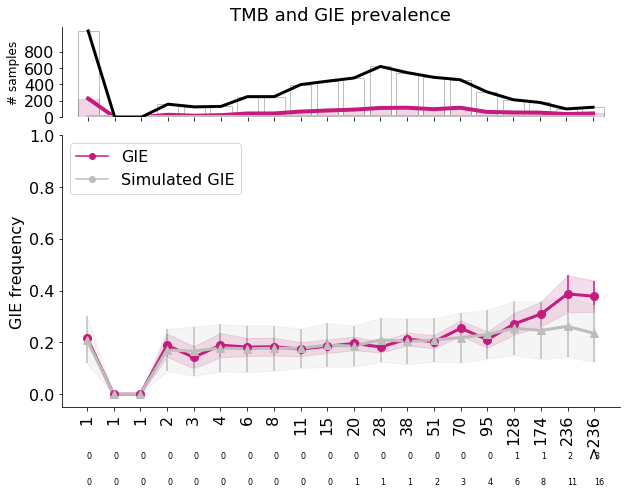

In [95]:

values_y,thresholds,sizes,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="selected_genetic_immune_escape",column_eval="log_subclonal_neo")
v=[]
for i in range(100):
    values_y_background,_,sizes_bk,_ = generate_randomizations_tmb_buckets(df_background,nbins=20,thresholds_given=thresholds,generate_thresholds=False,simulations=1,column_query=f"background_genetic_immune_escape_{i}",column_eval="log_subclonal_neo")
    v.append(values_y_background)

values_y_background=np.array(v).T[0]
plot_risk_multiple([values_y,values_y_background],thresholds,title="TMB and GIE prevalence",sizes_total=sizes_total,sizes=[sizes,np.zeros(len(sizes))],colors=["#c51b7d","#bdbdbd"],ylabel="GIE frequency"
                   ,name="excl_nfloh_gie_combined_with_simulated_gie_subclonal_neo",savefig=True,markers=["o","^"]
                   ,ylim=(-0.05,1.0),labels=["GIE","Simulated GIE"],sizeplot=(10,7),plot_total=True,transform="TML",plot_axvline=False)

### Split by type of GIE

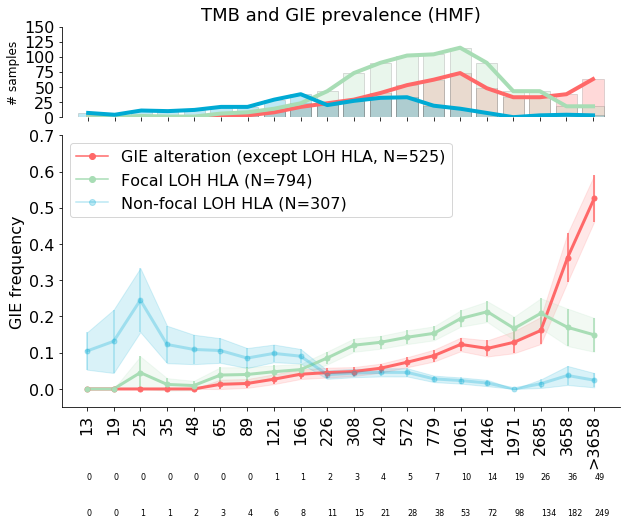

In [104]:
df["flag"] = df.apply(lambda row: row["genetic_immune_escape"] and not(row["loh_lilac"]),axis=1)
df["loh_focal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_focal"]),axis=1)
df["loh_nonfocal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_nonfocal"]),axis=1)

values_y,thresholds,sizes_gie,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="flag",column_eval="log_neo")
values_y_loh,thresholds,sizes_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_focal_flag",column_eval="log_neo")
values_y_loh2,thresholds,sizes_non_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_nonfocal_flag",column_eval="log_neo")


plot_risk_multiple([values_y,values_y_loh,values_y_loh2],thresholds,title="TMB and GIE prevalence (HMF)",sizes_total=sizes_total,sizes=[sizes_gie,sizes_foc,sizes_non_foc],colors=["#FF6868","#a8ddb5","#00aad445"],
                   ylabel="GIE frequency",savefig=True,name="gie_loh_focal_model_comb_neo",ylim=(-0.05,0.7),transform="TML",plot_axvline=False,sizeplot=(10,7),
                  labels=[f"GIE alteration (except LOH HLA, N={sum(sizes_gie)})",f"Focal LOH HLA (N={sum(sizes_foc)})",f"Non-focal LOH HLA (N={sum(sizes_non_foc)})"])



### Split by specific pathway

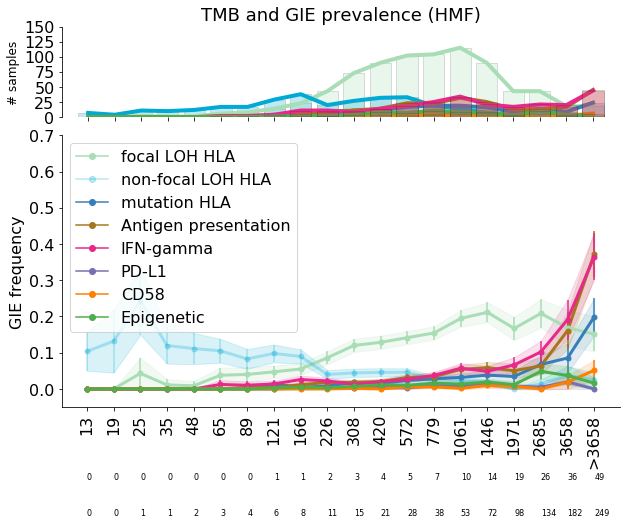

In [105]:

df["flag"] = df.apply(lambda row: row["genetic_immune_escape"] and not(row["loh_lilac"]),axis=1)
df["loh_focal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_focal"]),axis=1)
df["loh_nonfocal_flag"] = df.apply(lambda row: row["loh_lilac"] and "HLA" in str(row["loh_nonfocal"]),axis=1)
#'systemic_app_pathway',        'cd58_pathway',  'ifn_gamma_pathway',  'checkpoint_pathway', 'epigenetic_regulators_pathway',

values_y_loh,thresholds,sizes_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_focal_flag",column_eval="log_neo")
values_y_loh2,thresholds,sizes_non_foc,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="loh_nonfocal_flag",column_eval="log_neo")
values_y_mut,thresholds,sizes_mut,_=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="mut_hla_lilac",column_eval="log_neo")
values_y1,thresholds,sizes_gie1,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="systemic_app_pathway",column_eval="log_neo")
values_y2,thresholds,sizes_gie2,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="ifn_gamma_pathway",column_eval="log_neo")
values_y3,thresholds,sizes_gie3,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="checkpoint_pathway",column_eval="log_neo")
values_y4,thresholds,sizes_gie4,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="cd58_pathway",column_eval="log_neo")
values_y5,thresholds,sizes_gie5,sizes_total=generate_randomizations_tmb_buckets(df,20,simulations=1000,column_query="epigenetic_regulators_pathway",column_eval="log_neo")


plot_risk_multiple([values_y_loh,values_y_loh2,values_y_mut,values_y1,values_y2,values_y3,values_y4,values_y5],thresholds,title="TMB and GIE prevalence (HMF)",sizes_total=sizes_total,sizes=[sizes_foc,sizes_non_foc,sizes_mut,sizes_gie1,sizes_gie2,sizes_gie3,sizes_gie4,sizes_gie5],colors=["#a8ddb5","#00aad445","#377eb8","#a6761d","#e7298a","#7570b3","#ff7f00","#4daf4a"],ylabel="GIE frequency"
                   ,savefig=True
                   ,transform="TML",plot_axvline=False
                   ,name="gie_loh_focal_model_comb_full_all_pathways_neoepitopes"
                   ,ylim=(-0.05,0.7),labels=["focal LOH HLA","non-focal LOH HLA","mutation HLA","Antigen presentation","IFN-gamma","PD-L1","CD58","Epigenetic"],sizeplot=(10,7))##4d9221"

In [43]:
(1.46%) - https://www.nature.com/articles/s43018-021-00197-6
(6%) - https://doi.org/10.1016/j.cell.2020.09.015
(5%)  - https://doi.org/10.1016/j.xcrm.2021.100194 <- Cited there

array([  10. ,  309.5,  609. ,  908.5, 1208. , 1507.5, 1807. , 2106.5,
       2406. , 2705.5, 3005. , 3304.5, 3604. , 3903.5, 4203. , 4502.5,
       4802. , 5101.5, 5401. , 5700.5])